# Data preparation and ingestion

In [1]:
# Imports
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
from elasticsearch import Elasticsearch
from statistics import median
from transformers import BigBirdModel, BigBirdTokenizer, LongformerTokenizer, LongformerModel
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

## Load the data

In [2]:
# Load in Pandas df
data_path = "../data/ancient_sources.csv.gz"
df = pd.read_csv(data_path, compression="gzip")
df.head()

,author,title,section,text
0,Aeschylus,Agamemnon,lines 1-39,Release from this weary task of mine has been ...
1,Euripides,Ion,lines 1-40,Before the Temple of Apollo at Delphi . The su...
2,Euripides,Heracles,lines 1-25,Before the palace of Heracles at Thebes . Near...
3,Euripides,Hippolytus,lines 1-33,Aphrodite enters above the skene. Aphrodite Ap...
4,Euripides,Heracleidae,lines 1-47,The skene represents the temple of Zeus Agorai...


In [4]:
# Check size
df.shape

(111709, 4)

## Data cleaning and EDA

In [5]:
# Append index as ID
df['Id'] = df.index

In [13]:
# Delete rows without text or section
df.drop(df[df["section"].isna()].index, inplace=True)
df.drop(df[df["text"].isna()].index, inplace=True)

In [14]:
# Check new size
df.shape

(111584, 5)

In [15]:
# Create a function that counts number of words of a text
def count_words(text):
    return len(text.split())

# Append a column with the number of words of the texts
df["num_words"] = df["text"].apply(count_words)

# Show first rows
df.head()

,author,title,section,text,Id,num_words
0,Aeschylus,Agamemnon,lines 1-39,Release from this weary task of mine has been ...,0,445
1,Euripides,Ion,lines 1-40,Before the Temple of Apollo at Delphi . The su...,1,357
2,Euripides,Heracles,lines 1-25,Before the palace of Heracles at Thebes . Near...,2,279
3,Euripides,Hippolytus,lines 1-33,Aphrodite enters above the skene. Aphrodite Ap...,3,349
4,Euripides,Heracleidae,lines 1-47,The skene represents the temple of Zeus Agorai...,4,554


In [16]:
df["num_words"].describe()

count    111584.000000
mean        178.670365
std         363.700589
min           1.000000
25%          58.000000
50%          94.000000
75%         173.000000
max       31177.000000
Name: num_words, dtype: float64

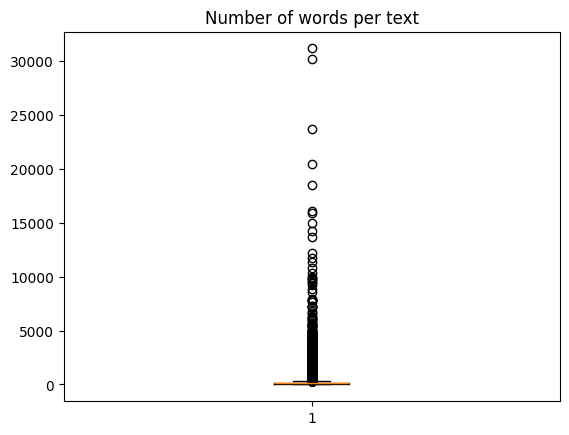

In [17]:
# Boxplot
boxplot_stats = plt.boxplot(df['num_words'])
plt.title('Number of words per text');

In [18]:
whiskers = [item.get_ydata() for item in boxplot_stats['whiskers']]
upp_whisker = whiskers[1][1]
print("Upper whisker:", upp_whisker)

Upper whisker: 345.0


In [21]:
df[df["num_words"] > 1000]

,author,title,section,text,Id,num_words
12,Diogenes Laertius,Lives of Eminent Philosophers,"BOOK I, Prologue",Prologue There are some who say that the study...,12,3233
20,M. Tullius Cicero,Letters,PREFACE,PREFACE The object of this book is to give the...,20,1099
38,Diogenes Laertius,Lives of Eminent Philosophers,"BOOK I, Chapter 1. THALES (floruit circa 585 B...","Chapter 1. THALES (floruit circa 585 B.C., the...",38,3490
70,Diogenes Laertius,Lives of Eminent Philosophers,"BOOK I, Chapter 2. SOLON (archon 594 B.C.)",Chapter 2. SOLON (archon 594 B.C.) [ 45 ] Solo...,70,3403
75,M. Tullius Cicero,Letters,Introduction,Introduction Ground covered by the Corresponde...,75,14254
...,...,...,...,...,...,...
95424,William Watson Goodwin,Syntax of the Moods and Tenses of the Greek Verb,In Object Clauses after Verbs of Striving etc.,In Object Clauses after Verbs of Striving etc....,95424,1058
95724,Athenaeus,The Deipnosophists,Book XI.,BOOK X. Ulysses -- Voracity of certain Persons...,95724,30158
103095,John Conington,"Commentary on Vergil's Aeneid, Volume 1","P. VERGILI MARONIS, lines 743, 744-744","[743, 744] These lines are among the hardest i...",103095,1285
109282,Titus Livius (Livy),"Ab urbe condita, Index","P., Prodigia",Prodigia Aedes Vulcani de coelo tacta 24.10 . ...,109282,1768


Although the limit stablished by boxplot is 320, we are not going to limit the length of the text. The BigBird (the model that we are going to use to generate the embbedings) tokenizer will truncate the texts that exceed the maximum context length (4096 tokens).

## Generate embeddings for vector search

In [10]:
# Transform into a list of dicts
# df_dict = df.to_dict(orient="records")

# Obtain list of texts
text_list = df["text"].tolist()

In [11]:
# Initialize tokenizer and model
model_name = "google/bigbird-roberta-base"
tokenizer = BigBirdTokenizer.from_pretrained(model_name)
model = BigBirdModel.from_pretrained(model_name)
model.eval();

/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return encoding


dataset = TextDataset(texts=text_list, tokenizer=tokenizer, max_length=4096)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
all_embeddings = []

with torch.no_grad():
    for batch in tqdm(dataloader):
        inputs = {key: value.squeeze(1) for key, value in batch.items()}  # Remove batch dimension
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Compute mean embedding
        all_embeddings.append(embeddings)

  0%|          | 0/10681 [00:00<?, ?it/s]